<b>Overview</b> <br>

This Notebook focuses on using sequential deep learning models (RNN, GRU, LSTM) for hate speech classification. You will reuse the preprocessed data from Lab 1 NoteBook and adapt it for sequential model architectures. <br>


<b>Steps<B>
1. Data Loading and Preparation<br>
2. Text Representation for Sequential Models <br>
3. Sequential Model Implementation<br>
4. Hyperparameter Tuning<br>
5. Experimentation and Analysis<br>
6. Evaluation<br>
7. Results and Discussion<br>

<b>Import Libraries</b>

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
# check if a GPU is available on tensorflow 
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<B>1. Data Loading and Preparation</B> <br>
    Load the preprocessed data <br>
    Convert text data into a sequential format suitable for RNNs<br>
    Tokenize text into sequences  
    Pad sequences to uniform length<br>
    Create embedding matrices (if using pre-trained embeddings)

In [2]:
# Ready preprocessed data from the previous notebook    
df = pd.read_csv("../Data/preprocessed_data.csv")   
df.head(10)    

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thanks lyft credit use cause offer wheelchair ...
2,0,bihday majesty
3,0,model love u take u time ur
4,0,factsguide society motivation
5,0,huge fan fare big talking leave chaos pay disp...
6,0,camping tomorrow dannya
7,0,next school year year exam think school exam h...
8,0,love land allin cavs champion cleveland clevel...
9,0,welcome gr


In [3]:
tweets  = df['tweet'].astype('str').tolist()
labels  = df['label'].tolist()

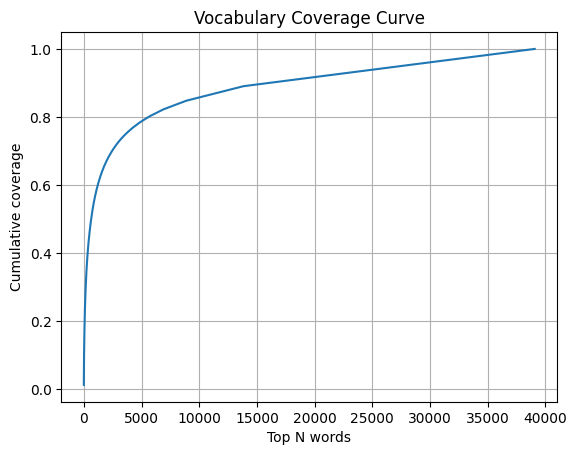

Top 30000 words cover 96.06% of total word usage


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from collections import Counter


tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(tweets)

word_counts = tokenizer.word_counts
sorted_counts = sorted(word_counts.values(),reverse=True)


# Calculate cumulative coverage
total = sum(sorted_counts)       # so we have 230208 word in the data (not unique)
cumulative = np.cumsum(sorted_counts) / total

# Plot vocab coverage
plt.plot(range(len(cumulative)), cumulative)
plt.xlabel("Top N words")
plt.ylabel("Cumulative coverage")
plt.title("Vocabulary Coverage Curve")
plt.grid(True)
plt.show()

# so from this plot we can say that making (MAX_NUM_WORDS) = 30000 will cover around 96% of data
print(f"Top 30000 words cover {cumulative[30000]*100:.2f}% of total word usage")


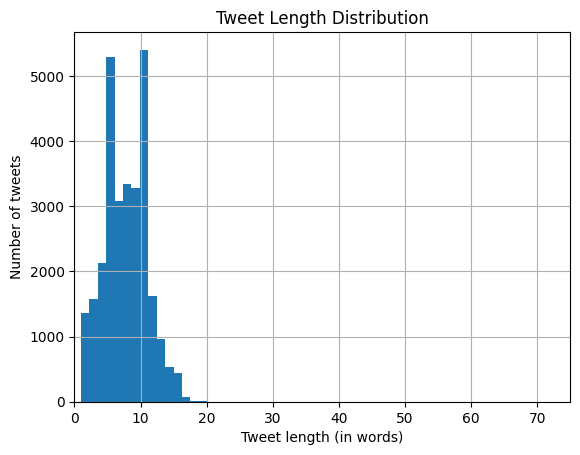

99% of tweets are shorter than 15 words


In [5]:
sequences = tokenizer.texts_to_sequences(tweets)

sequences_length = [len(seq) for seq in sequences]

# Plot length distribution
plt.hist(sequences_length, bins=1000)
plt.xlim(0,75)
plt.xlabel("Tweet length (in words)")
plt.ylabel("Number of tweets")
plt.title("Tweet Length Distribution")
plt.grid(True)
plt.show()

# What length covers 95% of tweets?
max_len = int(np.percentile(sequences_length, 99))
print(f"99% of tweets are shorter than {max_len} words")

# so we will make >>  MAX_SEQUENCE_LENGTH = 30 >> i think it will be suitable

In [6]:
# Parameters
MAX_NUM_WORDS = 30000  # adjust based on vocab size
MAX_SEQUENCE_LENGTH = 30  # length to pad/truncate to
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets)

sequences = tokenizer.texts_to_sequences(tweets)

# making padding and truncating = post >>> to pad or truncate at the end of the sequence
padded = pad_sequences(sequences , maxlen = MAX_SEQUENCE_LENGTH , padding='post', truncating='post')
# print(padded) #    the shape is (29130, 30)

word_index = tokenizer.word_index
# print(len(word_index))

<b>Before Any Embeddings >> we should split the data to avoid any leakage </b>

In [7]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test  = train_test_split(padded , labels , test_size=0.1 , random_state=99, stratify=labels)

print(x_train.shape , x_test.shape )

(26217, 30) (2913, 30)


<b>Note from the previous Notebook we have an imbalance on the data - in NLP we can Deal with this Imbalance by  </b> <br>

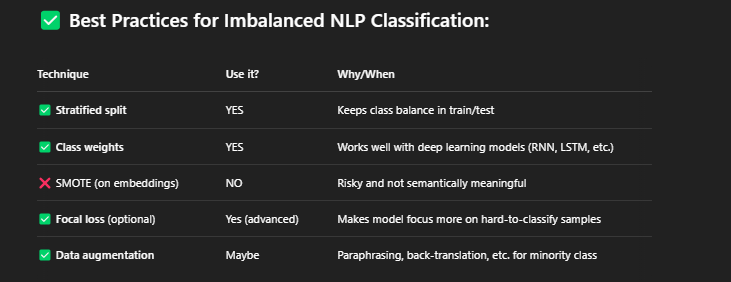


In [8]:
# Applying Class weight to use it later when (fitting) training the model
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))  

print(class_weights)


{0: 0.5366178156214181, 1: 7.32727780883175}


In [9]:
y_train = np.array(y_train)
y_test = np.array(y_test)

<b>After that we should make Word Embedding for each index represent each word. And we have 4 ways to do that </b>

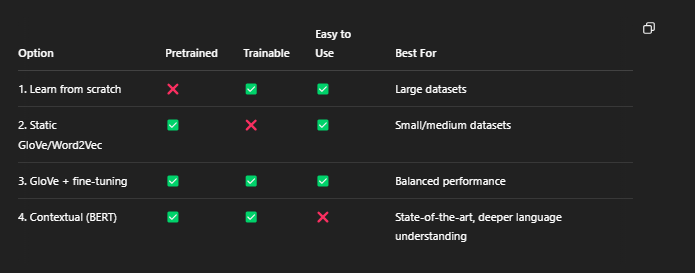

<B>2. Text Representation for Sequential Models</B> <br>
Random initialization <br>
Pre-trained word embeddings<br>
Word2Vec <br>
GloVe<br>
FastText


In [10]:
from tensorflow.keras.layers import Embedding
import gensim.downloader as api 

In [11]:
# 1 - Random Initialization (Trainable from scratch)

embedding_layer_random = Embedding(
    input_dim = MAX_NUM_WORDS,
    output_dim = EMBEDDING_DIM , 
    input_length = MAX_SEQUENCE_LENGTH , 
    trainable = True       # learns during training             
)

In [12]:
# 2 - Embeddings Using GLOVE 

embedding_index_glove = {}

with open("../models/glove.6B.100d.txt",encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],dtype='float32')
        embedding_index_glove[word] = vector

embedding_matrix_glove = np.zeros((MAX_NUM_WORDS,EMBEDDING_DIM))
for word , i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index_glove.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[i] = embedding_vector
    


embedding_layer_glove = Embedding(
    input_dim = MAX_NUM_WORDS,  
    output_dim = EMBEDDING_DIM , 
    input_length = MAX_SEQUENCE_LENGTH , 
    weights = [embedding_matrix_glove],
    trainable = True           
)

# print(embedding_matrix_glove.shape)    # (30000, 100)

In [13]:
# 2 - Embeddings Using Word2Vec  
 
embedding_index_word2vec = {}
EMBEDDING_DIM = 100

with open("../models/word2vec.txt",encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],dtype='float32')
        embedding_index_word2vec[word] = vector

embedding_matrix_word2vec = np.zeros((MAX_NUM_WORDS,EMBEDDING_DIM))
for word , i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index_word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix_word2vec[i] = embedding_vector
    


embedding_layer_word2vec = Embedding(
    input_dim = MAX_NUM_WORDS,  
    output_dim = EMBEDDING_DIM , 
    input_length = MAX_SEQUENCE_LENGTH , 
    weights = [embedding_matrix_word2vec],
    trainable = True          
)

# print(embedding_matrix_word2vec.shape)    # (30000, 100)

In [14]:
# 3 -  FastText (better for OOV words)

# load FastText embeddings from gensim and save it to models file
# fasttext_embeddings = api.load('fasttext-wiki-news-subwords-300')
# fasttext_embeddings.save_word2vec_format('../models/fasttext_embeddings.vec', binary=False)

embedding_index_fasttext = {}
EMBEDDING_DIM = 300

with open("../models/fasttext_embeddings.vec",encoding='utf-8') as f:
    next(f)  # Skip header line
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],dtype='float32')
        embedding_index_fasttext[word] = vector

embedding_matrix_fasttext = np.zeros((MAX_NUM_WORDS,EMBEDDING_DIM))
for word , i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
    


embedding_layer_fasttext = Embedding(
    input_dim = MAX_NUM_WORDS,  
    output_dim = EMBEDDING_DIM , 
    input_length = MAX_SEQUENCE_LENGTH , 
    weights = [embedding_matrix_fasttext],    
    trainable = True       # learns during training             
)   

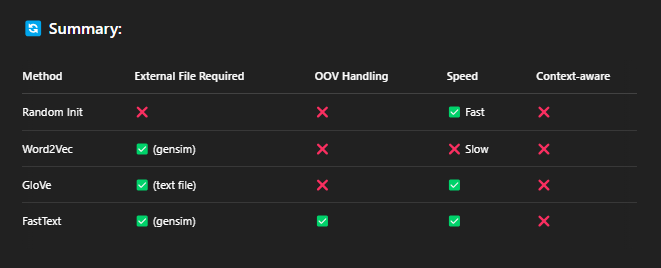

<h2><b>Let's go to the modeling Zone</b><h2>

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding , SimpleRNN , Dense , Bidirectional , GRU, LSTM, Dropout, GlobalMaxPooling1D , BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
#  Step 1: Build a Baseline Simple RNN Model
model_1 = Sequential([
    embedding_layer_random,
    SimpleRNN(32 ,return_sequences=False),
    Dense(1 , activation='sigmoid')
])

model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           3000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,004,289
Trainable params: 3,004,289
Non-trainable params: 0
_________________________________________________________________


In [17]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [19]:
history = model_1.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test,y_test),
    callbacks=[callback],
    class_weight=class_weights
)

Epoch 1/10
205/205 [==============================] - 13s 44ms/step - loss: 0.4705 - accuracy: 0.7901 - val_loss: 0.2497 - val_accuracy: 0.9080
Epoch 2/10
205/205 [==============================] - 9s 42ms/step - loss: 0.1812 - accuracy: 0.9383 - val_loss: 0.3472 - val_accuracy: 0.8716
Epoch 3/10
205/205 [==============================] - 8s 40ms/step - loss: 0.0705 - accuracy: 0.9764 - val_loss: 0.2328 - val_accuracy: 0.9193
Epoch 4/10
205/205 [==============================] - 8s 41ms/step - loss: 0.0327 - accuracy: 0.9880 - val_loss: 0.2508 - val_accuracy: 0.9238
Epoch 5/10
205/205 [==============================] - 8s 41ms/step - loss: 0.0193 - accuracy: 0.9936 - val_loss: 0.2446 - val_accuracy: 0.9276
Epoch 6/10
205/205 [==============================] - 8s 40ms/step - loss: 0.0157 - accuracy: 0.9950 - val_loss: 0.2513 - val_accuracy: 0.9406
Epoch 6: early stopping


In [20]:
print("model Evaluation on test data :" , model_1.evaluate(x_test,y_test))    

92/92 [==============================] - 1s 10ms/step - loss: 0.2328 - accuracy: 0.9193
model Evaluation on test data : [0.23275183141231537, 0.9193271398544312]


92/92 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2714
           1       0.44      0.70      0.54       199

    accuracy                           0.92      2913
   macro avg       0.71      0.82      0.75      2913
weighted avg       0.94      0.92      0.93      2913



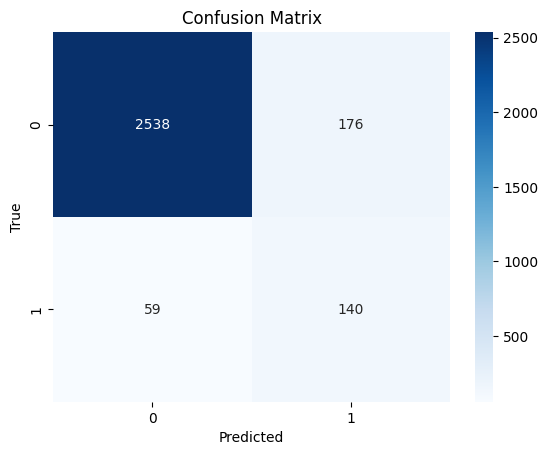

In [21]:
# Predict
y_pred_probs = model_1.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


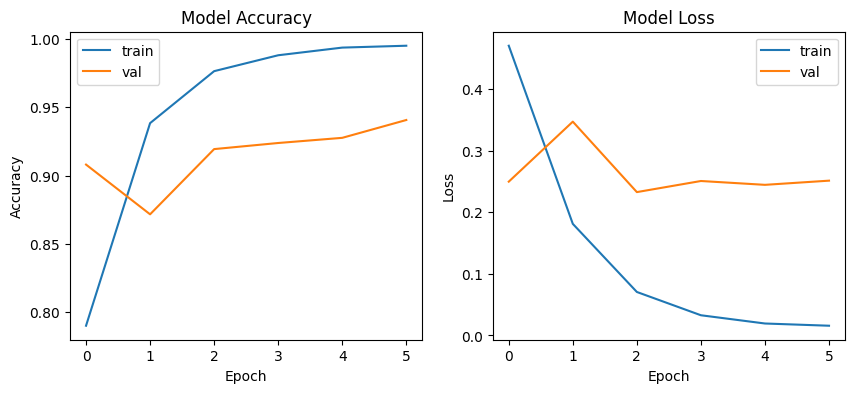

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


In [23]:
# 2 - Trying fasttext embedding + make it trainable
model_2 = Sequential([
    embedding_layer_fasttext,
    SimpleRNN(64 ,return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32 ,return_sequences=False),
    Dense(64 , activation='relu'),
    Dropout(0.2),
    Dense(1 , activation='sigmoid')
])

model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 300)           9000000   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 30, 64)            23360     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [24]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [27]:
history = model_2.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test,y_test),
    callbacks=[callback],
    class_weight=class_weights
)

Epoch 1/10


205/205 [==============================] - 19s 91ms/step - loss: 0.1679 - accuracy: 0.9438 - val_loss: 0.2489 - val_accuracy: 0.9152
Epoch 2/10
205/205 [==============================] - 18s 90ms/step - loss: 0.0834 - accuracy: 0.9716 - val_loss: 0.3022 - val_accuracy: 0.8987
Epoch 3/10
205/205 [==============================] - 18s 88ms/step - loss: 0.0372 - accuracy: 0.9865 - val_loss: 0.2272 - val_accuracy: 0.9341
Epoch 4/10
205/205 [==============================] - 17s 84ms/step - loss: 0.0231 - accuracy: 0.9910 - val_loss: 0.3168 - val_accuracy: 0.9258
Epoch 5/10
205/205 [==============================] - 18s 88ms/step - loss: 0.0139 - accuracy: 0.9946 - val_loss: 0.2875 - val_accuracy: 0.9331
Epoch 6/10
205/205 [==============================] - 19s 90ms/step - loss: 0.0710 - accuracy: 0.9718 - val_loss: 0.2265 - val_accuracy: 0.9289
Epoch 7/10
205/205 [==============================] - 17s 85ms/step - loss: 0.0406 - accuracy: 0.9840 - val_loss: 0.3611 - val_accuracy: 0.9186
Epo

In [28]:
print("model Evaluation on test data :" , model_2.evaluate(x_test,y_test))

92/92 [==============================] - 1s 14ms/step - loss: 0.2265 - accuracy: 0.9289
model Evaluation on test data : [0.2264782041311264, 0.9289392232894897]


92/92 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2714
           1       0.48      0.64      0.55       199

    accuracy                           0.93      2913
   macro avg       0.73      0.80      0.76      2913
weighted avg       0.94      0.93      0.93      2913



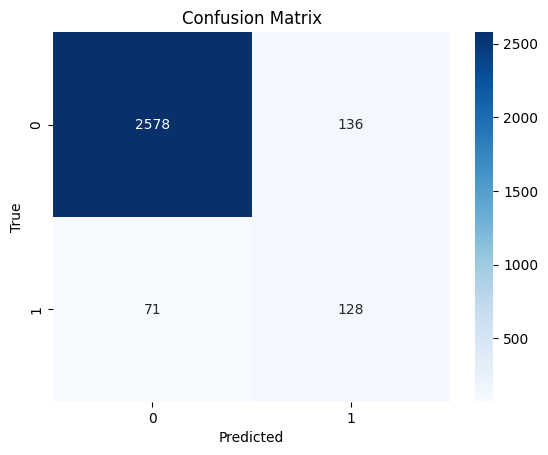

In [29]:
# Predict
y_pred_probs = model_2.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

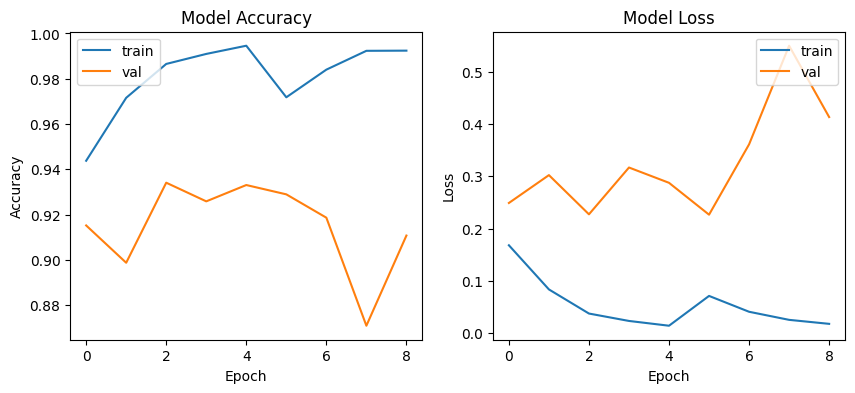

In [30]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(['train', 'val'], loc='upper right')
plt.show()

<b>Out of this i think it's enough to apply fasttext Embeddings + make the model params it trainable not freezing it to combine the advantage of both </b> <br>

--------------------------------------------------------------------------------------------------------------------
SO LET US FOCUS ON MODELS (RNN - GRU - LSTM) With hyperparams

In [31]:
# trying to bidirectional RNN with 2 layers
model_3 = Sequential([
    embedding_layer_fasttext,
    Bidirectional(SimpleRNN(64 ,return_sequences=True)),
    Dropout(0.2),
    Bidirectional(SimpleRNN(32 ,return_sequences=False)),
    Dense(64 , activation='relu'),
    Dropout(0.2),
    Dense(1 , activation='sigmoid')
])

model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 300)           9000000   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          46720     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               10304     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [32]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model_3.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test,y_test),
    callbacks=[callback],
    class_weight=class_weights
)

Epoch 1/10
205/205 [==============================] - 45s 205ms/step - loss: 0.1008 - accuracy: 0.9629 - val_loss: 0.2409 - val_accuracy: 0.9276
Epoch 2/10
205/205 [==============================] - 32s 158ms/step - loss: 0.0225 - accuracy: 0.9920 - val_loss: 0.2944 - val_accuracy: 0.9300
Epoch 3/10
205/205 [==============================] - 36s 175ms/step - loss: 0.0147 - accuracy: 0.9953 - val_loss: 0.2785 - val_accuracy: 0.9348
Epoch 4/10
205/205 [==============================] - 35s 172ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.3708 - val_accuracy: 0.9152
Epoch 4: early stopping


In [33]:
print("model Evaluation on test data :" , model_3.evaluate(x_test,y_test))    

92/92 [==============================] - 3s 27ms/step - loss: 0.2409 - accuracy: 0.9276
model Evaluation on test data : [0.2409161478281021, 0.9275661110877991]


 1/92 [..............................] - ETA: 5s

92/92 [==============================] - 3s 31ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2714
           1       0.48      0.73      0.58       199

    accuracy                           0.93      2913
   macro avg       0.73      0.84      0.77      2913
weighted avg       0.95      0.93      0.93      2913



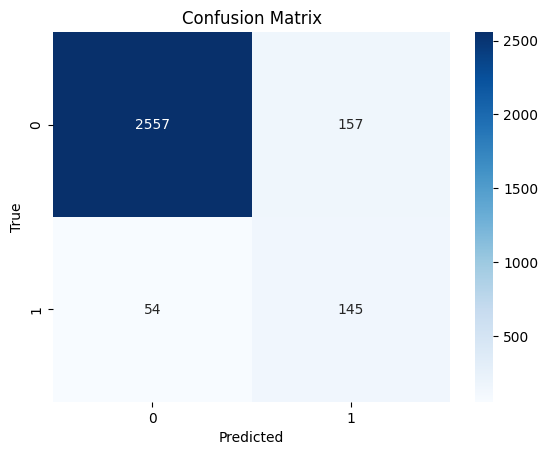

In [36]:
# Predict
y_pred_probs = model_3.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)    

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')    
plt.xlabel("Predicted")
plt.ylabel("True")    
plt.title("Confusion Matrix")
plt.show()

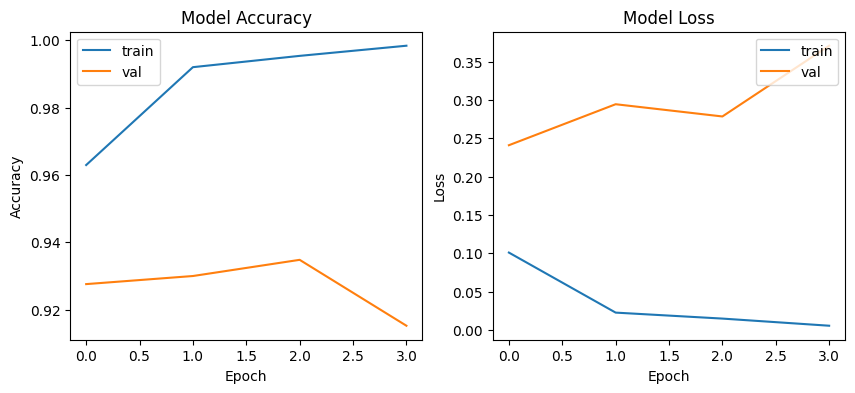

In [37]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)    
plt.plot(history.history['loss'])    
plt.plot(history.history['val_loss'])    
plt.title('Model Loss')    
plt.ylabel('Loss')    
plt.xlabel('Epoch')                     
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [79]:
# After trying fasttext on simple RNN and bidirectional RNN on 2 layers there is no improvement in model performance
# so i think we should try LSTM or GRU

In [ ]:
# 3 - Trying fasttext embedding + make it trainable on GRU
model_4 = Sequential([
    embedding_layer_fasttext,
    GRU(64 ,return_sequences=False),
    Dense(1 , activation='sigmoid')
])

model_4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_4.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 15, 300)           9000000   
                                                                 
 gru (GRU)                   (None, 64)                70272     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,070,337
Trainable params: 9,070,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callaback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1   
)

history = model_4.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test,y_test),
    callbacks=[callaback],
    class_weight=class_weights
)

Epoch 1/10
160/160 [==============================] - 2s 14ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.4791 - val_accuracy: 0.9119
Epoch 2/10
160/160 [==============================] - 2s 14ms/step - loss: 0.0046 - accuracy: 0.9978 - val_loss: 0.4086 - val_accuracy: 0.9284
Epoch 3/10
160/160 [==============================] - 2s 14ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.4289 - val_accuracy: 0.9281
Epoch 4/10
160/160 [==============================] - 2s 13ms/step - loss: 0.0032 - accuracy: 0.9984 - val_loss: 0.3892 - val_accuracy: 0.9320
Epoch 5/10
160/160 [==============================] - 2s 12ms/step - loss: 0.0028 - accuracy: 0.9987 - val_loss: 0.4663 - val_accuracy: 0.9249
Epoch 6/10
160/160 [==============================] - 2s 13ms/step - loss: 0.0021 - accuracy: 0.9990 - val_loss: 0.4466 - val_accuracy: 0.9320
Epoch 7/10
160/160 [==============================] - 2s 13ms/step - loss: 0.0029 - accuracy: 0.9987 - val_loss: 0.4288 - val_accuracy: 0.9309

In [ ]:
model_4.evaluate(x_test,y_test)

137/137 [==============================] - 1s 4ms/step - loss: 0.4135 - accuracy: 0.9325


[0.4135306179523468, 0.9324788451194763]

137/137 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4071
           1       0.50      0.64      0.57       298

    accuracy                           0.93      4369
   macro avg       0.74      0.80      0.76      4369
weighted avg       0.94      0.93      0.94      4369



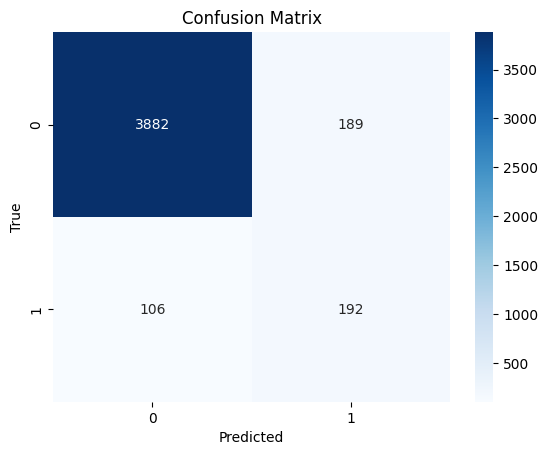

In [ ]:
# predict
y_pred_probs = model_4.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# report
print(classification_report(y_test, y_pred))

# confusion matrix  
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")    
plt.show()  

In [88]:
# let's use bidirectional GRU on 2 layers
model_5 = Sequential([
    embedding_layer_fasttext,
    Bidirectional(GRU(128 ,return_sequences=True)),
    Dropout(0.2),
    Bidirectional(GRU(64 ,return_sequences=True)),
    Dropout(0.2),
    Bidirectional(GRU(32 ,return_sequences=False)),
    Dense(64 , activation='relu'),
    Dropout(0.2),
    Dense(1 , activation='sigmoid')
])

model_5.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 300)           9000000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 30, 256)          330240    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 30, 256)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 30, 128)          123648    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 30, 128)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)              

In [ ]:
callaback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1   
)

history = model_5.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test,y_test),
    callbacks=[callaback],
    class_weight=class_weights  
)

Epoch 1/10
183/183 [==============================] - 22s 49ms/step - loss: 0.1066 - accuracy: 0.9706 - val_loss: 0.3983 - val_accuracy: 0.8874
Epoch 2/10
183/183 [==============================] - 8s 43ms/step - loss: 0.0301 - accuracy: 0.9897 - val_loss: 0.3550 - val_accuracy: 0.9039
Epoch 3/10
183/183 [==============================] - 8s 41ms/step - loss: 0.0131 - accuracy: 0.9944 - val_loss: 0.3405 - val_accuracy: 0.9303
Epoch 4/10
183/183 [==============================] - 8s 41ms/step - loss: 0.0105 - accuracy: 0.9964 - val_loss: 0.3929 - val_accuracy: 0.9053
Epoch 5/10
183/183 [==============================] - 8s 41ms/step - loss: 0.0065 - accuracy: 0.9974 - val_loss: 0.4350 - val_accuracy: 0.9234
Epoch 6/10
183/183 [==============================] - 7s 41ms/step - loss: 0.0131 - accuracy: 0.9953 - val_loss: 0.7091 - val_accuracy: 0.8318
Epoch 6: early stopping


In [92]:
model_5.evaluate(x_test,y_test)

92/92 [==============================] - 2s 18ms/step - loss: 0.3061 - accuracy: 0.9331


[0.3061051070690155, 0.9330586791038513]

 1/92 [..............................] - ETA: 3s

92/92 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2714
           1       0.51      0.71      0.59       199

    accuracy                           0.93      2913
   macro avg       0.74      0.83      0.78      2913
weighted avg       0.95      0.93      0.94      2913



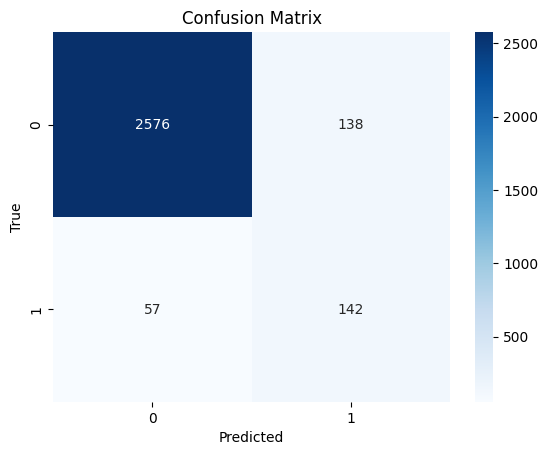

In [93]:
# predict
y_pred_probs = model_5.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# report
print(classification_report(y_test, y_pred))        

# confusion matrix  
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")    
plt.show()


In [98]:
# try word2vec embedding on GRU + make it trainable
model = Sequential([
    embedding_layer_word2vec,
    GRU(64 ,return_sequences=False),
    Dense(1 , activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 15, 100)           3000000   
                                                                 
 gru_4 (GRU)                 (None, 64)                31872     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,031,937
Trainable params: 3,031,937
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callaback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1   
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test,y_test),
    callbacks=[callaback],
    class_weight=class_weights
)   

Epoch 1/10
160/160 [==============================] - 4s 14ms/step - loss: 0.4978 - accuracy: 0.6737 - val_loss: 0.3022 - val_accuracy: 0.8794
Epoch 2/10
160/160 [==============================] - 2s 10ms/step - loss: 0.2324 - accuracy: 0.9137 - val_loss: 0.2958 - val_accuracy: 0.8824
Epoch 3/10
160/160 [==============================] - 2s 11ms/step - loss: 0.1068 - accuracy: 0.9621 - val_loss: 0.1903 - val_accuracy: 0.9371
Epoch 4/10
160/160 [==============================] - 2s 10ms/step - loss: 0.0456 - accuracy: 0.9834 - val_loss: 0.1934 - val_accuracy: 0.9474
Epoch 5/10
160/160 [==============================] - 2s 10ms/step - loss: 0.0233 - accuracy: 0.9917 - val_loss: 0.2809 - val_accuracy: 0.9227
Epoch 6/10
160/160 [==============================] - 2s 10ms/step - loss: 0.0175 - accuracy: 0.9936 - val_loss: 0.2284 - val_accuracy: 0.9270
Epoch 6: early stopping


In [100]:
model.evaluate(x_test,y_test)

137/137 [==============================] - 1s 6ms/step - loss: 0.1871 - accuracy: 0.9368


[0.18706189095973969, 0.9368276596069336]

137/137 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      4071
           1       0.53      0.73      0.61       298

    accuracy                           0.94      4369
   macro avg       0.75      0.84      0.79      4369
weighted avg       0.95      0.94      0.94      4369



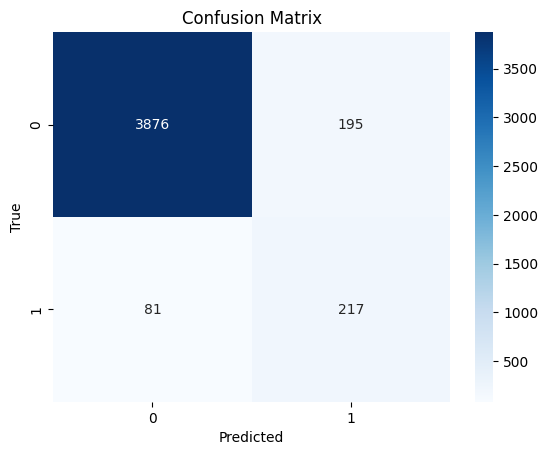

In [101]:
# predict
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# report
print(classification_report(y_test, y_pred))

# confusion matrix  
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")    
plt.show()  

In [102]:
# apply word2vec embedding on bidirectional GRU on 2 layers
model = Sequential([
    embedding_layer_word2vec,
    Bidirectional(GRU(128 ,return_sequences=True)),
    Bidirectional(GRU(64 ,return_sequences=True)),
    Bidirectional(GRU(32 ,return_sequences=False)),
    Dense(1 , activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary() 

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 15, 100)           3000000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 15, 256)          176640    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 15, 128)          123648    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                     

In [ ]:
callaback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1   
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test,y_test),
    callbacks=[callaback],
    class_weight=class_weights
)


Epoch 1/10
160/160 [==============================] - 15s 42ms/step - loss: 0.1511 - accuracy: 0.9446 - val_loss: 0.2417 - val_accuracy: 0.9085
Epoch 2/10
160/160 [==============================] - 5s 32ms/step - loss: 0.0519 - accuracy: 0.9794 - val_loss: 0.2609 - val_accuracy: 0.9108
Epoch 3/10
160/160 [==============================] - 5s 33ms/step - loss: 0.0267 - accuracy: 0.9896 - val_loss: 0.2367 - val_accuracy: 0.9288
Epoch 4/10
160/160 [==============================] - 5s 33ms/step - loss: 0.0167 - accuracy: 0.9937 - val_loss: 0.2450 - val_accuracy: 0.9346
Epoch 5/10
160/160 [==============================] - 5s 32ms/step - loss: 0.0118 - accuracy: 0.9951 - val_loss: 0.2804 - val_accuracy: 0.9323
Epoch 6/10
160/160 [==============================] - 5s 33ms/step - loss: 0.0149 - accuracy: 0.9936 - val_loss: 0.2607 - val_accuracy: 0.9384
Epoch 6: early stopping


In [104]:
model.evaluate(x_test,y_test)

137/137 [==============================] - 2s 13ms/step - loss: 0.2303 - accuracy: 0.9334


[0.2303369790315628, 0.9333943724632263]

137/137 [==============================] - 3s 12ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4071
           1       0.51      0.66      0.58       298

    accuracy                           0.93      4369
   macro avg       0.74      0.81      0.77      4369
weighted avg       0.94      0.93      0.94      4369



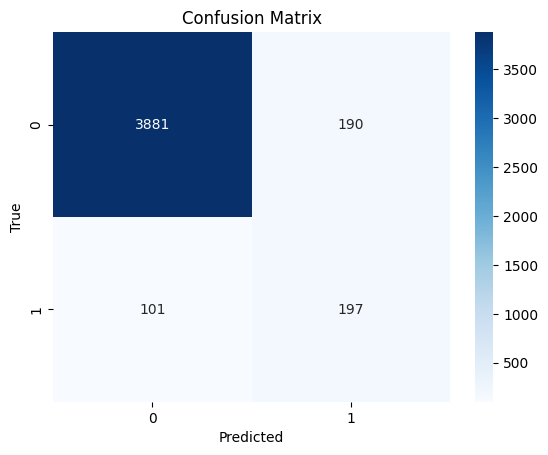

In [105]:
# predict
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# report
print(classification_report(y_test, y_pred))

# confusion matrix  
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")    
plt.show()

In [21]:
# let's try word2vec embedding on lstm + make it trainable
best_model = Sequential([
    embedding_layer_fasttext,                          # Word2Vec embedding (trainable=True)
    
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),  # Bidirectional LSTM with dropout
    
    Dense(64, activation='relu'),
    Dropout(0.4),    
    Dense(1, activation='sigmoid')                     # Output for binary classification
])

best_model.compile(
    optimizer='adam',                                  # You can also try RMSprop or AdamW
    loss='binary_crossentropy',
    metrics=['accuracy']
)

best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 300)           9000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               85248     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,089,473
Trainable params: 9,089,473
Non-trainable params: 0
____________________________________________

In [22]:
callaback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1   
)

history = best_model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test,y_test),
    callbacks=[callaback],
    class_weight=class_weights  
)

Epoch 1/10


205/205 [==============================] - 87s 400ms/step - loss: 0.2358 - accuracy: 0.9297 - val_loss: 0.3370 - val_accuracy: 0.8740
Epoch 2/10
205/205 [==============================] - 88s 430ms/step - loss: 0.0749 - accuracy: 0.9743 - val_loss: 0.2149 - val_accuracy: 0.9307
Epoch 3/10
205/205 [==============================] - 93s 456ms/step - loss: 0.0378 - accuracy: 0.9863 - val_loss: 0.2998 - val_accuracy: 0.9090
Epoch 4/10
205/205 [==============================] - 88s 429ms/step - loss: 0.0258 - accuracy: 0.9890 - val_loss: 0.3045 - val_accuracy: 0.9214
Epoch 5/10
205/205 [==============================] - 86s 417ms/step - loss: 0.0185 - accuracy: 0.9932 - val_loss: 0.2775 - val_accuracy: 0.9344
Epoch 6/10
205/205 [==============================] - 84s 411ms/step - loss: 0.0122 - accuracy: 0.9949 - val_loss: 0.3424 - val_accuracy: 0.9365
Epoch 7/10
205/205 [==============================] - 83s 403ms/step - loss: 0.0101 - accuracy: 0.9963 - val_loss: 0.3744 - val_accuracy: 0.9

In [23]:
best_model.evaluate(x_test,y_test)   

92/92 [==============================] - 4s 47ms/step - loss: 0.2149 - accuracy: 0.9307


[0.21490438282489777, 0.9306556582450867]

92/92 [==============================] - 4s 40ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2714
           1       0.50      0.80      0.61       199

    accuracy                           0.93      2913
   macro avg       0.74      0.87      0.79      2913
weighted avg       0.95      0.93      0.94      2913



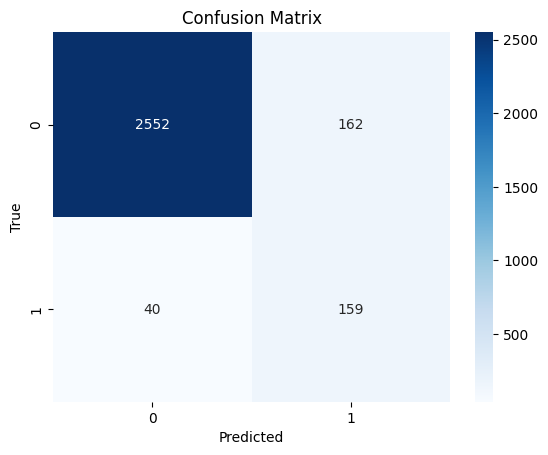

In [24]:
# predict
y_pred_probs = best_model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)    

# report
print(classification_report(y_test, y_pred))

# confusion matrix  
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  

plt.xlabel("Predicted")
plt.ylabel("True")    
plt.title("Confusion Matrix")    
plt.show()

In [67]:
# let's try fasttext embedding on lstm + make it trainable
model = Sequential([
    embedding_layer_fasttext,
    LSTM(64 ,return_sequences=False),
    Dense(1 , activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 300)           9000000   
                                                                 
 lstm_3 (LSTM)               (None, 64)                93440     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,093,505
Trainable params: 9,093,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callaback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1   
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test,y_test),
    callbacks=[callaback],
    class_weight=class_weights  
)

Epoch 1/10
160/160 [==============================] - 5s 18ms/step - loss: 0.1188 - accuracy: 0.9659 - val_loss: 0.3123 - val_accuracy: 0.9254
Epoch 2/10
160/160 [==============================] - 2s 14ms/step - loss: 0.0199 - accuracy: 0.9945 - val_loss: 0.2801 - val_accuracy: 0.9334
Epoch 3/10
160/160 [==============================] - 2s 14ms/step - loss: 0.0091 - accuracy: 0.9979 - val_loss: 0.4422 - val_accuracy: 0.8908
Epoch 4/10
160/160 [==============================] - 2s 14ms/step - loss: 0.0056 - accuracy: 0.9979 - val_loss: 0.4273 - val_accuracy: 0.9165
Epoch 5/10
160/160 [==============================] - 2s 13ms/step - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.4519 - val_accuracy: 0.9281
Epoch 5: early stopping


In [120]:
model.evaluate(x_test,y_test)

137/137 [==============================] - 1s 4ms/step - loss: 0.2996 - accuracy: 0.9272


[0.29957446455955505, 0.9272144436836243]

137/137 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4071
           1       0.48      0.65      0.55       298

    accuracy                           0.93      4369
   macro avg       0.72      0.80      0.75      4369
weighted avg       0.94      0.93      0.93      4369



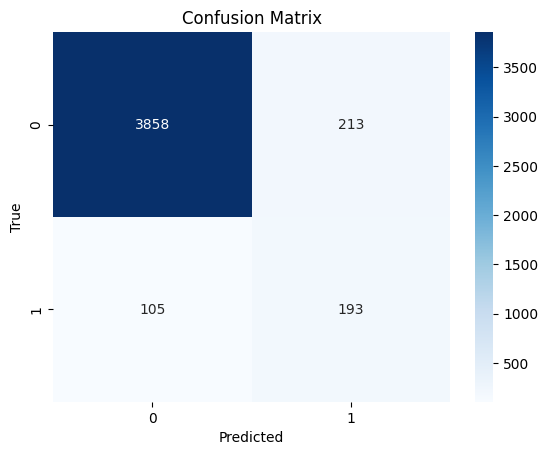

In [121]:
# predict
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)    

# report
print(classification_report(y_test, y_pred))

# confusion matrix  
cm = confusion_matrix(y_test, y_pred)    

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  

plt.xlabel("Predicted")    
plt.ylabel("True")    
plt.title("Confusion Matrix")    
plt.show()    

In [ ]:
# let's try word2vec embedding on Bidirectional LSTM + make it trainable
model_10 = Sequential([
    embedding_layer_word2vec,                      # pretrained Word2Vec (trainable=True)
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    GlobalMaxPooling1D(),                          # flatten the sequence, keeps most informative features
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')                 # binary classification
])

model_10.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_10.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 100)           3000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 30, 256)          234496    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 30, 256)           0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dropout_7 (Dropout)         (None, 64)               

In [40]:
casllback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1   
)

history = model_10.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test,y_test),
    callbacks=[casllback],
    class_weight=class_weights  
)

Epoch 1/10


205/205 [==============================] - 11s 25ms/step - loss: 0.4366 - accuracy: 0.7779 - val_loss: 0.4829 - val_accuracy: 0.7504
Epoch 2/10
205/205 [==============================] - 4s 22ms/step - loss: 0.2343 - accuracy: 0.9040 - val_loss: 0.2081 - val_accuracy: 0.9118
Epoch 3/10
205/205 [==============================] - 4s 20ms/step - loss: 0.0916 - accuracy: 0.9656 - val_loss: 0.1432 - val_accuracy: 0.9440
Epoch 4/10
205/205 [==============================] - 4s 21ms/step - loss: 0.0423 - accuracy: 0.9834 - val_loss: 0.2007 - val_accuracy: 0.9313
Epoch 5/10
205/205 [==============================] - 4s 21ms/step - loss: 0.0306 - accuracy: 0.9881 - val_loss: 0.1961 - val_accuracy: 0.9379
Epoch 6/10
205/205 [==============================] - 4s 20ms/step - loss: 0.0234 - accuracy: 0.9913 - val_loss: 0.1756 - val_accuracy: 0.9451
Epoch 6: early stopping


In [42]:
model_10.evaluate(x_test,y_test)   

92/92 [==============================] - 1s 10ms/step - loss: 0.1432 - accuracy: 0.9440


[0.1432221531867981, 0.9440439343452454]

92/92 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2714
           1       0.57      0.73      0.64       199

    accuracy                           0.94      2913
   macro avg       0.78      0.84      0.80      2913
weighted avg       0.95      0.94      0.95      2913



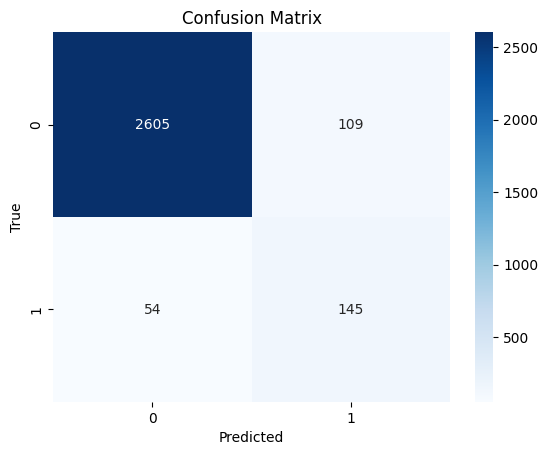

In [43]:
# predict
y_pred_probs = model_10.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# report
print(classification_report(y_test, y_pred))

# confusion matrix  
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")    
plt.show()

<b>With A lot of trails i found that using word2vec + trainable with LSTM is the best one</b>

In [25]:
def classify_custom_tweet(tweet_text):
    # Clean the tweet using your function

    # Convert text to sequence using your trained tokenizer
    sequence = tokenizer.texts_to_sequences([tweet_text])
    # Pad the sequence (exactly like training)
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    # Make prediction
    prediction = best_model.predict(padded_sequence, verbose=0)
    
    sentiment = "Negative" if prediction >= 0.5 else "Positive"  # Assuming 1=Negative, 0=Positive

    return {
        "probability": float(prediction),
        "sentiment": sentiment
    }

In [27]:
# input = "fuck you" 
input = "we live to love"

result = classify_custom_tweet(input)
print(f"Predicted Sentiment: {result['sentiment']} (Confidence: {result['probability']:.4f})")

Predicted Sentiment: Positive (Confidence: 0.0821)


C:\Users\aliay\AppData\Local\Temp\ipykernel_22232\3142429989.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "probability": float(prediction),
